In [1]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup, AutoModelForSequenceClassification
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv("../input/app-reviews/reviews.csv")

In [3]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

In [4]:
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner,2
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner,2
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner,2
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner,2


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


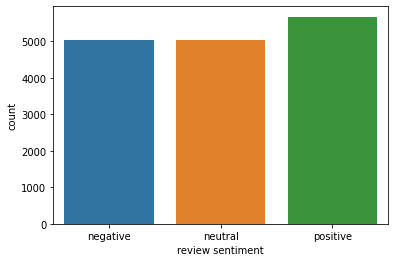

In [5]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

Я пробовал другие модели, но засоряется видеопамять сильно на большое количество экспериментов в одной тетрадке

In [7]:
from transformers import AutoTokenizer, AutoModel
model_name = 'j-hartmann/emotion-english-distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [8]:
train_labels, val_labels, test_labels = list(df_train.sentiment), list(df_val.sentiment), list(df_test.sentiment)

In [9]:
train_texts, val_texts, test_texts = list(df_train.content), list(df_val.content), list(df_test.content)

In [10]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_token_type_ids=False, max_length=512, return_attention_mask = True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_token_type_ids=False, max_length=512, return_attention_mask = True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_token_type_ids=False, max_length=512, return_attention_mask = True)

In [11]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GPReviewDataset(train_encodings, train_labels)
val_dataset = GPReviewDataset(val_encodings, val_labels)
test_dataset = GPReviewDataset(test_encodings, test_labels)

In [12]:
batch_ex = next(iter(test_dataset))

### Вроде тут все стандартно, кроме того, что функция потерь считается внутри форварда для трейнера. Взято из примера huggingface на гитхабе

In [13]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        
        output = self.drop(pooled_output)
        logits = self.out(output)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [14]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

Some weights of the model checkpoint at j-hartmann/emotion-english-distilroberta-base were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for p

### Поставил weighed т.к. у нас три класса

In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Я тестировал на маленьком берте, а потом взял побольше и для сентимент. Так что 3 эпохи для хорошего размера должно хватить. Report_tо для запуска в кеггле

In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    report_to='tensorboard'
)

In [17]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2658


Step,Training Loss
10,1.146800
20,1.131200
30,1.130800
40,1.070300
50,1.037500
60,0.953100
70,0.943000
80,0.885500
90,0.898700
100,0.853900


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2658, training_loss=0.5550111586030396, metrics={'train_runtime': 1173.029, 'train_samples_per_second': 36.242, 'train_steps_per_second': 2.266, 'total_flos': 0.0, 'train_loss': 0.5550111586030396, 'epoch': 3.0})

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'eval_loss': 0.5106960535049438,
 'eval_accuracy': 0.8398983481575604,
 'eval_f1': 0.840202279383861,
 'eval_precision': 0.8405905450202918,
 'eval_recall': 0.8398983481575604,
 'eval_runtime': 7.39,
 'eval_samples_per_second': 106.496,
 'eval_steps_per_second': 6.766,
 'epoch': 3.0}

In [19]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'test_loss': 0.5052164793014526,
 'test_accuracy': 0.8236040609137056,
 'test_f1': 0.8251158318309084,
 'test_precision': 0.8284370574570347,
 'test_recall': 0.8236040609137056,
 'test_runtime': 5.1886,
 'test_samples_per_second': 151.872,
 'test_steps_per_second': 9.637,
 'epoch': 3.0}

In [20]:
del model
torch.cuda.empty_cache()

# Используем cls без линейного слоя

In [21]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifierWithCLS(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        # первый токен
        cls_token = last_hidden_state[:,0,:]
        output = self.drop(pooled_output)
        concated = torch.cat((cls_token, output), 1)
        logits = self.out(concated)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [22]:
model2 = SentimentClassifierWithCLS(3)

loading configuration file https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cf0d76ef122b326527bd6a56a127784dd513117bdfde0df5b011c9751bce8fd6.512111953428ded6703782e47e2f67b1c438267f7f4a7c0f19bc1850651a93b4
Model config RobertaConfig {
  "_name_or_path": "j-hartmann/emotion-english-distilroberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "disgust",
    "2": "fear",
    "3": "joy",
    "4": "neutral",
    "5": "sadness",
    "6": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "s

In [23]:
trainer = Trainer(
    model=model2,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2658


Step,Training Loss
10,1.145900
20,1.092200
30,1.076400
40,1.052600
50,0.982600
60,0.926500
70,0.888700
80,0.849200
90,0.857700
100,0.836100


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2658, training_loss=0.5435642863773061, metrics={'train_runtime': 1176.2329, 'train_samples_per_second': 36.143, 'train_steps_per_second': 2.26, 'total_flos': 0.0, 'train_loss': 0.5435642863773061, 'epoch': 3.0})

In [24]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'eval_loss': 0.5467703938484192,
 'eval_accuracy': 0.8360864040660737,
 'eval_f1': 0.8367005779348139,
 'eval_precision': 0.8376910090211003,
 'eval_recall': 0.8360864040660737,
 'eval_runtime': 7.3699,
 'eval_samples_per_second': 106.786,
 'eval_steps_per_second': 6.784,
 'epoch': 3.0}

In [25]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
del model2
torch.cuda.empty_cache()

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


# Готовая голова

In [26]:
model3 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)

loading configuration file https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cf0d76ef122b326527bd6a56a127784dd513117bdfde0df5b011c9751bce8fd6.512111953428ded6703782e47e2f67b1c438267f7f4a7c0f19bc1850651a93b4
Model config RobertaConfig {
  "_name_or_path": "j-hartmann/emotion-english-distilroberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attent

In [27]:
trainer = Trainer(
    model=model3,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2658


Step,Training Loss
10,1.114400
20,1.096400
30,1.062700
40,1.019700
50,0.978800
60,0.972200
70,0.876400
80,0.858400
90,0.869000
100,0.860600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2658, training_loss=0.5466011800740875, metrics={'train_runtime': 1178.8913, 'train_samples_per_second': 36.062, 'train_steps_per_second': 2.255, 'total_flos': 5631686950413312.0, 'train_loss': 0.5466011800740875, 'epoch': 3.0})

In [28]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'eval_loss': 0.5260424017906189,
 'eval_accuracy': 0.8284625158831004,
 'eval_f1': 0.8290263473601113,
 'eval_precision': 0.8297830860849251,
 'eval_recall': 0.8284625158831004,
 'eval_runtime': 7.3613,
 'eval_samples_per_second': 106.911,
 'eval_steps_per_second': 6.792,
 'epoch': 3.0}

In [29]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
del model3
torch.cuda.empty_cache()

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


# CLS на нескольких слоях

### Я соединю вектора и передам получившуюся длину в линейный слой

In [30]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifierWithMultipleCLS(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size*self.bert.config.num_hidden_layers, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output, hidden_states = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False,
          output_hidden_states=True
        )

        concated = None
        for state in hidden_states[1:]:
            cls_token = state[:,0,:]
            if concated is not None:
                concated = torch.cat((cls_token, concated), 1)
            else:
                concated = cls_token
        logits = self.out(concated)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [31]:
model4 = SentimentClassifierWithMultipleCLS(3)

loading configuration file https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cf0d76ef122b326527bd6a56a127784dd513117bdfde0df5b011c9751bce8fd6.512111953428ded6703782e47e2f67b1c438267f7f4a7c0f19bc1850651a93b4
Model config RobertaConfig {
  "_name_or_path": "j-hartmann/emotion-english-distilroberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "disgust",
    "2": "fear",
    "3": "joy",
    "4": "neutral",
    "5": "sadness",
    "6": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "s

In [32]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    report_to='tensorboard'
)

PyTorch: setting up devices


In [33]:
trainer = Trainer(
    model=model4,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5316


Step,Training Loss
10,1.237600
20,1.186300
30,1.109000
40,1.047200
50,1.018500
60,1.017500
70,0.937300
80,0.908200
90,0.861700
100,0.834700


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-4000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model chec

TrainOutput(global_step=5316, training_loss=0.5417291307870924, metrics={'train_runtime': 1282.192, 'train_samples_per_second': 33.157, 'train_steps_per_second': 4.146, 'total_flos': 0.0, 'train_loss': 0.5417291307870924, 'epoch': 3.0})

In [34]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 8


{'eval_loss': 0.613969087600708,
 'eval_accuracy': 0.8462515883100381,
 'eval_f1': 0.8465191286496045,
 'eval_precision': 0.8469955656169499,
 'eval_recall': 0.8462515883100381,
 'eval_runtime': 7.6705,
 'eval_samples_per_second': 102.6,
 'eval_steps_per_second': 12.907,
 'epoch': 3.0}

In [35]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
del model4
torch.cuda.empty_cache()

***** Running Evaluation *****
  Num examples = 788
  Batch size = 8


### Выше я конкатенировал векторы, теперь попробую взять среднее по всем

In [36]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class SentimentClassifierWithMultipleCLS2(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_classes = n_classes
  
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None
    ):
        
        last_hidden_state, pooled_output, hidden_states = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False,
          output_hidden_states=True
        )

        all_hidden_states = torch.stack(hidden_states)
        cls_embs = torch.mean(all_hidden_states[:, :, 0], 0)
        
        logits = self.out(cls_embs)
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1).to(device))        
        output = (logits,)
        
        return ((loss,) + output) if loss is not None else output 

In [37]:
model5 = SentimentClassifierWithMultipleCLS2(3)

loading configuration file https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cf0d76ef122b326527bd6a56a127784dd513117bdfde0df5b011c9751bce8fd6.512111953428ded6703782e47e2f67b1c438267f7f4a7c0f19bc1850651a93b4
Model config RobertaConfig {
  "_name_or_path": "j-hartmann/emotion-english-distilroberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "disgust",
    "2": "fear",
    "3": "joy",
    "4": "neutral",
    "5": "sadness",
    "6": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "s

In [38]:
trainer = Trainer(
    model=model5,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
    # metrics to evaluate
)

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5316


Step,Training Loss
10,1.158100
20,1.202200
30,1.220700
40,1.190600
50,1.107000
60,1.082400
70,1.077800
80,1.046800
90,1.021400
100,0.974400


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-3500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-4000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model chec

TrainOutput(global_step=5316, training_loss=0.5514331146951365, metrics={'train_runtime': 1292.1364, 'train_samples_per_second': 32.901, 'train_steps_per_second': 4.114, 'total_flos': 0.0, 'train_loss': 0.5514331146951365, 'epoch': 3.0})

In [39]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 8


{'eval_loss': 0.5452734231948853,
 'eval_accuracy': 0.8424396442185514,
 'eval_f1': 0.8433133785893978,
 'eval_precision': 0.8446799660244834,
 'eval_recall': 0.8424396442185514,
 'eval_runtime': 7.746,
 'eval_samples_per_second': 101.6,
 'eval_steps_per_second': 12.781,
 'epoch': 3.0}

In [40]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
del model5
torch.cuda.empty_cache()

***** Running Evaluation *****
  Num examples = 788
  Batch size = 8


# Тест на отзывах

In [41]:
twostar = """Why react isn't registering fast, I liked something and then scroll down, After sometime I saw the post and my reaction wasn't there. Not one time, this happens everytime. Don't blame the internet, it's pretty fast here.Fix the problem , otherwise I'm gonna decrease my rating even more."""

In [42]:
fivestar = """Hi I really love this app cause it's light on storage, less data consumption but you said it work in any network condition ahh. No it's not working on any network condition even in 4G network still slow. And this issue I encounter is so annoying . When I'm watching videos and when I'm at the best moment or best scene of the video it kicks me out of the app and automatically back to start where I open the app and I can't find the video so please fix this issue 😊"""

In [43]:
threestar = """Hi, good evening. I have a challenge. I've been trying to update my profile, and upload my stories but it's not working. And whenever i tried to do so, it automatically exits. Please help me out. Thanks, though your app is amazing, but i think there should be more features like . Been able to change my color, just the way I can switch to night mode."""

In [44]:
from torch.nn.functional import softmax

def get_sent(sentence, model):
    encoding = tokenizer.encode_plus(
      sentence,
      max_length=512,
      add_special_tokens=True, 
      return_token_type_ids=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',  
      truncation=True
    ).to(device)
    
    return softmax(model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0], dim=1)

In [45]:
get_sent(twostar, model)

NameError: name 'model' is not defined

In [ ]:
get_sent(threestar, model4)

In [ ]:
get_sent(fivestar, model4)

In [ ]:
fivestar_2 = """Great experience when one uses the face life app. It's the best of the season. We encourage everyone to share it with friends and family as well as with the different social media groups. Its good for business, social activities, relationships, friends search, research, marketing, learning new ideas. This is a global market for the season. It's free for people with open minded ideas about life ideas. It's an opportunity for jobs and creativity. It's a meeting place for tourists and visiting"""

In [ ]:
get_sent(fivestar_2, model4)